In [37]:
import numpy as np,matplotlib.pyplot as plt,pandas as pd

In [38]:
from matplotlib.widgets import Slider, Button, RadioButtons
from scipy.stats import norm
%matplotlib notebook
%matplotlib inline

In [39]:
def call_payoff(S,K, premium=0.0, qty=1,long=True):
    payoff=np.maximum(S-K,0)- premium
    return payoff * qty if long else -payoff * qty
def put_payoff(S,K, premium=0.0, qty=1,long=True):
    payoff=np.maximum(K-S,0)- premium
    return payoff * qty if long else -payoff * qty
def combined_payoff(S,legs):
    total=np.zeros_like(S)
    for leg in legs:
        if leg['type']=="C":
          total+=call_payoff(S,leg['K'],premium=leg['premium'],qty=leg['qty'],long=leg['long'])
        else:
          total+=put_payoff(S,leg['K'],premium=leg['premium'],qty=leg['qty'],long=leg['long'])
    return total

In [40]:
# monte carlo GBM simulator for prob of profit, median and loss

In [41]:
def simulate_ST(S0,mu,sigma,T_Days,n_sims=12000,seed=42):
  np.random.seed(seed)
  T=max(T_Days,0)/252.0
  if T==0:
    return np.full(n_sims, S0) # all paths equal to S0

  # Generate random shocks
  Z = np.random.randn(n_sims)
  # Geometric Brownian Motion formula
  ST = S0 * np.exp((mu - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)
  return ST

def expected_metrics_via_mc(legs,S0,mu,sigma,T_Days,n_sims=12000,seed=42):
  ST=simulate_ST(S0,mu,sigma,T_Days,n_sims,seed)
  sim_payoffs=np.array([combined_payoff(np.array([s]),legs)[0] for s in ST])
  ev=sim_payoffs.mean()
  prob_profit=(sim_payoffs>0).mean()
  median=np.median(sim_payoffs)
  prob_loss=(sim_payoffs<0).mean()
  return{"ev":ev,"prob_profit":prob_profit,"median":median,"prob_loss":prob_loss}


In [42]:
#Analytics

In [43]:
def breakeven(S,payoff):
    signs=np.sign(payoff)
    idx=np.where(np.diff(signs)!=0)[0]
    be_points=[]
    for i in idx:
      x0,x1=S[i],S[i+1]
      y0,y1=payoff[i],payoff[i+1]
      if(y1-y0)==0:
        be=x0
      else:
        be=x0-y0*(x1-x0)/(y1-y0)
      be_points.append(be)
    return be_points

mu_default=0.6
S0_default=26100
strike_default=26000
premium_call_default=350.0
premium_put_default=300.0
qty_default=1.0
T_days_default=4
sigma_default=0.18

S_min_default=S0_default-5000
S_max_default=S0_default+5000
S=np.linspace(S_min_default,S_max_default,400)


In [44]:
#create strategies (straddle)
def make_straddle(K,p_call,p_put,qty):
    return [
        {"type":"C","K":K,"premium":p_call,"qty":qty,"long":True},
        {"type":"P","K":K,"premium":p_put,"qty":qty,"long":True}
          ]

In [45]:
#plotting and widgets

<IPython.core.display.Javascript object>

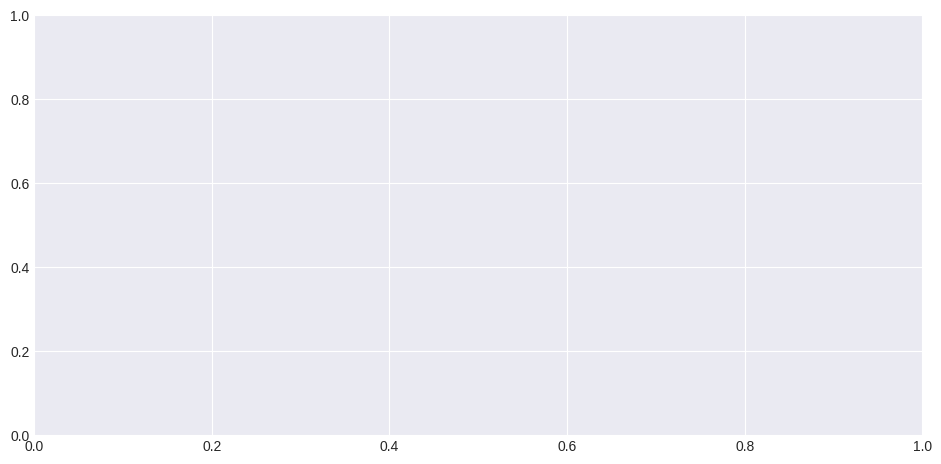

In [46]:
plt.style.use('seaborn-v0_8-darkgrid')
fig,ax=plt.subplots(figsize=(12,7))
plt.subplots_adjust(left=0.19,bottom=0.28,right=0.93)


In [47]:
#initial payoff line
legs=make_straddle(strike_default,premium_call_default,premium_put_default,qty_default)
payoff=combined_payoff(S,legs)
line_payoff,=ax.plot(S,payoff,lw=2,label='Long Straddle')

ax.axhline(0,color='k',lw=1)
ax.set_xlabel("Underlying price @ expiry")
ax.set_ylabel("profit/loss per unit")
ax.set_title("Interactive options strategy payoff with monte carlo simulator")
ax.legend(loc='upper left')

In [48]:
#vertical spot line and annotation text positions

In [49]:
from scipy import interpolate
vline=ax.axvline(S0_default, color='red',linestyle='--',lw=1.5)
spot_text=ax.text(0.02,0.95,"",transform=ax.transAxes,va='top')
be_text=ax.text(0.02,0.85,"",transform=ax.transAxes,va='top')
mc_text=ax.text(0.02,0.80,"",transform=ax.transAxes,va='top')
# filled areas
pos_fill=ax.fill_between(S,payoff,where=(payoff>=0),interpolate=True,alpha=.025)
neg_fill=ax.fill_between(S,payoff,where=(payoff<0),interpolate=True, alpha=0.25,color='tomato')


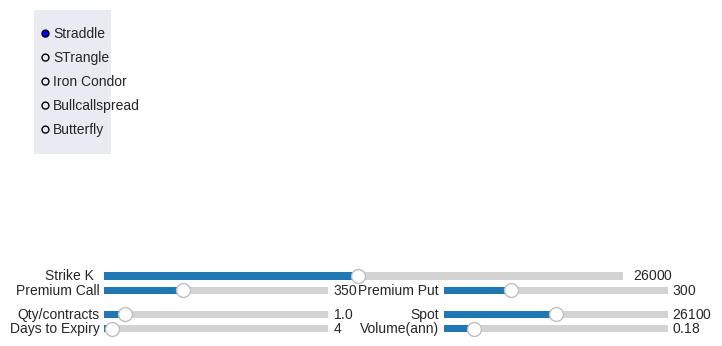

In [50]:
#slider axes layout
axstrike=plt.axes([0.12,0.13,0.81,0.03])
axpcall=plt.axes([0.12,0.10,0.35,0.03])
axpput=plt.axes([0.65,0.10,0.35,0.03])
axqty=plt.axes([0.12,0.05,0.35,0.03])
axspot=plt.axes([0.65,0.05,0.35,0.03])
axT=plt.axes([0.12,0.02,0.35,0.03])
axvol=plt.axes([0.65,0.02,0.35,0.03])
s_strike=Slider(axstrike,'Strike K',S_min_default,S_max_default,valinit=strike_default,valstep=50)
s_pcall=Slider(axpcall,'Premium Call',0.0,1000.0,valinit=premium_call_default)
s_pput=Slider(axpput,'Premium Put',0.0,1000.0,valinit=premium_put_default)
s_qty=Slider(axqty,'Qty/contracts',0.1,10.0,valinit=qty_default)
s_spot=Slider(axspot,'Spot',S_min_default,S_max_default,valinit=S0_default)
s_T=Slider(axT,'Days to Expiry',1,90,valinit=T_days_default,valstep=1)
s_vol=Slider(axvol,'Volume(ann)',0.05,1.0,valinit=sigma_default)

#RadioButtons for strategy selection(mutually exclusive)
axradio=plt.axes([0.01,0.4,0.12,0.30])
radio=RadioButtons(axradio,('Straddle','STrangle','Iron Condor','Bullcallspread','Butterfly'))
radio.set_active(0)

In [51]:
#strategy

In [52]:
def build_strategy_from_radio(K,p_call,p_put,qty):
    strategy=radio.value_selected
    if strategy=="Straddle":
        return make_straddle(K,p_call,p_put,qty), "long Straddle"
    elif strategy =='strangle':
        Kput=max(1,K-400)
        Kcall=min(K+400)
        legs=[
            {"type":"P","K":Kput,"premium":p_put*0.6,"qty":qty,"long":True},
            {"type":"C","K":Kcall,"premium":p_call*0.6,"qty":qty,"long":True},
        ]
        return legs,f"Long Strangle ({Kput}/{Kcall})"
    elif strategy=="Iron condor":
        legs=[
            {"type":"C","K":K+400,"premium":p_call*0.7,"qty":qty,"long":False}, #short call
            {"type":"C","K":K+800,"premium":p_call*0.3,"qty":qty,"long":True}, #Long call
            {"type":"P","K":K-400,"premium":p_put*0.7,"qty":qty,"long":False}, #short put
            {"type":"P","K":K-800,"premium":p_put*0.3,"qty":qty,"long":True}, #Long put
        ]
        return legs,"Iron condor(Synthetic levels)"
    elif strategy=="Bullcallspread":
        width=400
        K_buy=max(1,K-int(width/2))#lower strike
        K_sell=K_buy+width         #higher strike
        legs-[
            {"type":"C","K":K_buy,"premium":p_call*0.9,"qty":qty,"long":True},#but lower call
            {"type":"C","K":K_sell,"premium":p_call*0.5,"qty":qty,"long":False},#sell higher call

        ]
        return legs, f"bull call spread({K_buy}->{K_sell})"
    elif strategy=="Butterfly":
        wing=600
        K_low=K - wing
        K_mid=K
        K_high=K + wing
        legs-[
            {"type":"C","K":K_low,"premium":p_call*0.9,"qty":qty,"long":True},
            {"type":"C","K":K_mid,"premium":p_call*0.7,"qty":qty*2,"long":False},
            {"type":"C","K":K_high,"premium":p_call*0.9,"qty":qty*2,"long":True},
        ]
        return legs,f"LongButterfly({K_low},{K_mid},{K_high})"
    else:
        return make_straddle(K,p_call,p_put,qty), "long Straddle"


In [53]:
#update function
def update(val):
    K=s_strike.val
    p_call=s_pcall.val
    p_put=s_pput.val
    qty=s_qty.val
    spot_now=s_spot.val
    T_days=int(s_T.val)
    vol=s_vol.val
    current_legs,label=build_strategy_from_radio(K,p_call,p_put,qty)
    new_payoff=combined_payoff(S,current_legs)
    line_payoff.set_ydata(new_payoff)
    line_payoff.set_label(label)
    ax.legend(loc='upper right',frameon=True)

    #update fill
    global pos_fill,neg_fill
    try:
        pos_fill.remove()
        neg_fill.remove()
    except Exception:
        pass
    pos_fill=ax.fill_between(S,new_payoff,where=(new_payoff>=0),interpolate=True,alpha=.025)
    neg_fill=ax.fill_between(S,new_payoff,where=(new_payoff<0),interpolate=True, alpha=0.25,color='tomato')

    #breakevens
    bes=breakeven(S,new_payoff)
    be_str="Breakeven(s):"+(",".join([f"{b:.0f}"for b in bes])if bes else "None")
    be_text.set_text(be_str)

    #Monte carlo Analytics
    metrics=expected_metrics_via_mc(current_legs,spot_now,mu_default,vol,T_days,n_sims=12000)
    mc_str= (
        f"MC EV: {metrics['ev']:.1f}\n"
        f"Prob(Profit):{metrics['prob_profit']*100:.1f}%\n"
        f"Median:{metrics['median']:.1f}"
    )
    #set rich text properties
    mc_text.set_text(mc_str)
    mc_text.set_fontsize(11)
    mc_text.set_fontweight('bold')
    mc_text.set_color('purple')
    mc_text.set_bbox(dict(
        facecolor='white',alpha=0.9,edgecolor='black',boxstyle='round,pad=0.3'
    ))
    vline.set_xdata([spot_now,spot_now])
    spot_text.set_text(f"Spot:{spot_now:.0f} Strike K:{K:.0f} Qty: {qty:.2f}")
    fig.canvas.draw_idle()

#connect widgets
s_strike.on_changed(update)
s_pcall.on_changed(update)
s_pput.on_changed(update)
s_qty.on_changed(update)
s_spot.on_changed(update)
s_T.on_changed(update)
s_vol.on_changed(update)
radio.on_clicked(lambda _: update(None))

update(None)
plt.show()